In [1]:
!apt install swig
!pip install orthnet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

from orthnet import Legendre, Chebyshev

%matplotlib inline

GPU_MODE = True

In [3]:
if GPU_MODE:
  cuda0 = torch.device('cuda:0')
  print(torch.cuda.device_count(), torch.cuda.get_device_name(0))
  torch.cuda.init()

1 Tesla T4


In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [5]:
class LegendreActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 , i):
            if (i + j) % 2 == 1:
              self.D[i, j] = 2 * (j + 1) - 1
    
    def forward(self, X):              
      data = Legendre(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T


class LegendreBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Legendre = LegendreActivation(self.degree)

    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Legendre(X)
      return data

class ChebyshevActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 ,i):
            if (i+j) % 2 == 1:
              self.D[i, j] = 2 * i
              if j == 0:
                self.D[i, j] = self.D[i, j]/2.0
    def forward(self, X):              
      data = Chebyshev(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T

class ChebyshevBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Chebyshev = ChebyshevActivation(self.degree)


    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Chebyshev(X)
      
      return data

In [6]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

def d3y_dx3(y, x):
  return dy_dx(d2y_dx2(y,x), x)

In [7]:
domain = [0, 6]
n_discretization = 3000 * domain[1] - domain[0]

In [8]:
n_input = 1
n_output = 1
eps = 1e-10

In [9]:
if GPU_MODE:
  x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double, device=cuda0).reshape(-1,1)
  x = Variable(x, requires_grad=True).double()
else:
  x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double).reshape(-1,1)
  x = Variable(x, requires_grad=True).double()

In [10]:
mlp = nn.Sequential(  
  LegendreBlock(n_input, 32),
  nn.Linear(32, 64),
  nn.Tanh(),
  ChebyshevBlock(64, 128),
  nn.Linear(128, 64),
  nn.Tanh(),
  nn.Linear(64, 16),
  nn.Linear(16, n_output)
).double()


pytorch_total_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
pytorch_total_params

11492

In [11]:
if GPU_MODE:
  mlp.to('cuda:0')

In [12]:
# print(mlp(x))

In [13]:
def get_loss(x, ret_res=False):
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)
  y_xxx = dy_dx(y_xx, x)


  """    
  Blasius Eq.: 
   f''' + 0.5 ff'' = 0
   2f''' + ff'' = 0   ,   f(0) = f'(0) = 0, f'(∞) = 1
  """
  alpha = 0.5
  beta = -0.18
  # residual = (2 * y_xxx) + (y_xx * y)
  residual = (alpha * y_xxx) + (y_xx * y) + (beta * (1 - y_x**2))


  # boundaries same for all equations
  boundary1 = y[0]
  boundary2 = y_x[0]
  boundary3 = y_x[-1] - 1

  loss = (residual**2).mean() + boundary1**2 + boundary2**2 + boundary3**2
  return (loss, residual) if ret_res else loss

In [14]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [15]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.015, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 100
epoch_LBFGS = 10000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().cpu().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.015035)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().cpu().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 548521835.8145407438
Step: 002 loss = 13053558.7559010778
Step: 004 loss = 12511234.8501406647
Step: 006 loss = 55106649.4409794286
Step: 008 loss = 30320954.6998568028
Step: 010 loss = 9584192.3600941617
Step: 012 loss = 3086929.1642339067
Step: 014 loss = 2789409.7071550996
Step: 016 loss = 1991985.8398259343
Step: 018 loss = 1568870.0774063377
Step: 020 loss = 938955.6731043318
Step: 022 loss = 503769.0405800444
Step: 024 loss = 294368.1693576885
Step: 026 loss = 197615.2081717460
Step: 028 loss = 143957.5722675476
Step: 030 loss = 109325.8939295528
Step: 032 loss = 85346.3909430378
Step: 034 loss = 67296.7899393375
Step: 036 loss = 53345.5864833950
Step: 038 loss = 42693.3615563368
Step: 040 loss = 34723.0713270550
Step: 042 loss = 28880.3191472862
Step: 044 loss = 24678.8630011906
Step: 046 loss = 21699.0478879209
Step: 048 loss = 19585.2542291394
Step: 050 loss = 18047.9515374271
Step: 052 loss = 16865.8558322166
Step: 054 loss = 15883.3860210106
Step: 056 loss =

In [21]:
pd.options.display.float_format = '{:.16f}'.format
domain_test = torch.tensor([0.00,0.10,0.20,0.50,1.00,1.50,2.00], dtype=torch.double).reshape(-1,1)
predict_test = mlp.cpu().forward(domain_test).detach().numpy().flatten()
pd.DataFrame(np.array([domain_test.numpy().flatten(), predict_test]).T, columns=['x','y'])

,x,y
0,0.0000000000000000,0.0003612862458784
1,0.1000000000000000,-0.0004634249730317
2,0.2000000000000000,-0.0025420198663854
3,0.5000000000000000,-0.0162110721009475
4,1.0000000000000000,-0.0627259822449094
5,1.5000000000000000,-0.1358333839429754
6,2.0000000000000000,-0.2305966774931664


In [22]:
# calculate f''(0)
# # make zero Tensor from x Tensor
zerox = x.cpu().clone()
zerox[0][0] = 0
f_xx_0 = d2y_dx2(mlp(zerox), zerox)[0]
print("f''(0) = {}".format(f_xx_0[0]))



f''(0) = 0.1258283131536911


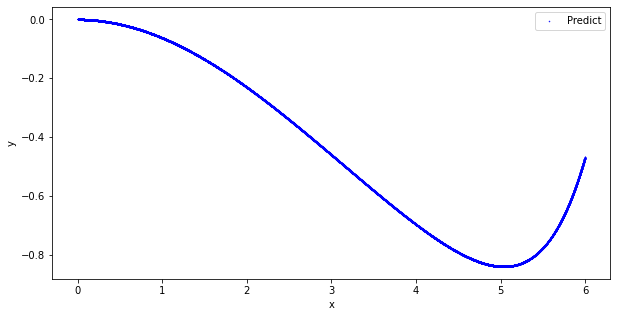

In [18]:
#[TODO]
domain = x.cpu().detach().numpy().flatten()
# exact = (1 - x**2 / 6).detach().numpy().flatten()
predict = mlp.forward(x.cpu()).detach().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')

# plt.plot(domain, exact,'k--', markersize=.1, label='Exact')
plt.plot(domain, predict,'b.', markersize=1, label='Predict')
plt.legend()

# plt.savefig('exact-predict.eps', bbox_inches='tight', format='eps')

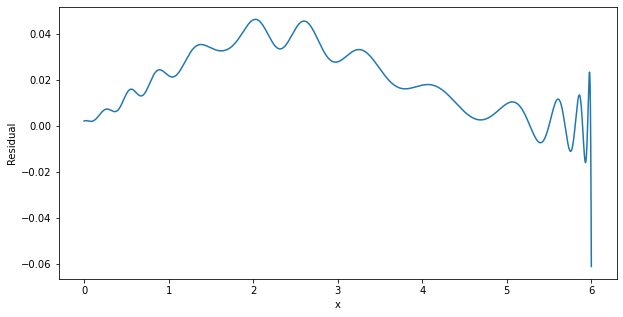

In [19]:
plt.figure(figsize=(10, 5))

res= get_loss(x.cpu(), ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

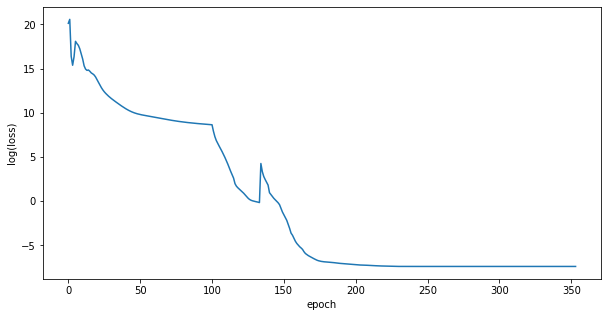

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')